In [1]:
import pandas as pd
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import random,math
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, Checkbox
from IPython.display import display, clear_output

In [2]:
df = pd.read_excel('../age_data.xls', skiprows=6)
male_df = pd.read_excel('../age_data.xls', sheet_name='m; 1950-2005, estimates', skiprows=6)
female_df = pd.read_excel('../age_data.xls', sheet_name='f; 1950-2005, estimates', skiprows=6)

In [3]:
df = df.replace('-', 0)
male_df = male_df.replace('-', 0)
female_df = female_df.replace('-', 0)
df[list(df.columns[6:])] = df[list(df.columns[6:])].astype('float')
male_df[list(male_df.columns[6:])] = male_df[list(male_df.columns[6:])].astype('float')
female_df[list(female_df.columns[6:])] = female_df[list(female_df.columns[6:])].astype('float')

Dropdown(description='Территория:', index=165, options=('AFRICA', 'ASIA', 'Afghanistan', 'Albania', 'Algeria',…

Dropdown(description='Период:', index=11, options=(1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995,…

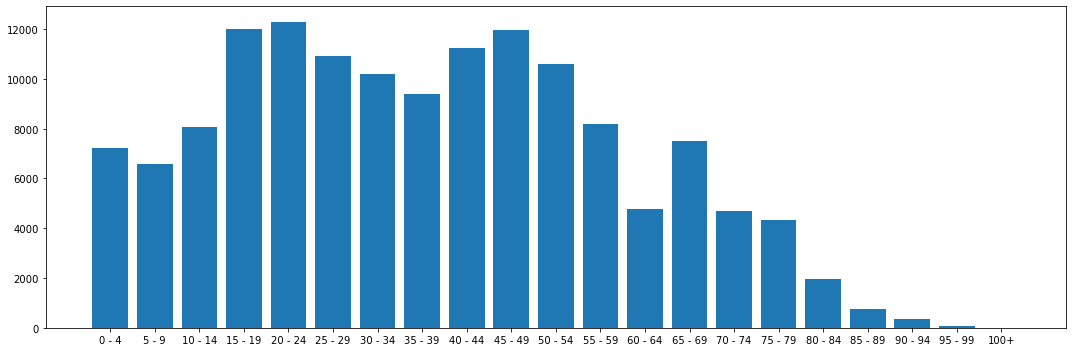

In [4]:
area = Dropdown(
    options=list(sorted(set(df.name))),
    value=list(sorted(set(df.name)))[0], # Выбор по умолчанию
    description='Территория:' 
)
date = Dropdown(
    options=list(sorted(set(df.date))),
    value=list(sorted(set(df.date)))[0], # Выбор по умолчанию
    description='Период:' 
)

display(area, date)

def on_button_clicked(*args):
    clear_output()
    display(area, date)
    
    global filter_country_df
    filter_country_df = df.loc[df.name == area.value]
    filter_df = filter_country_df.loc[filter_country_df.date == int(date.value)]
    bar_df = filter_df[list(filter_df.columns[6:])].transpose()

    plt.figure(figsize = (15, 5))
    plt.subplot(1,1,1)
    plt.bar(bar_df.index, bar_df[list(filter_df.index)[0]].to_list())
    plt.tight_layout()
    plt.show()

area.observe(on_button_clicked, names='value')
date.observe(on_button_clicked, names='value')
on_button_clicked()

In [5]:
name = area.value
name

'Russian Federation'

In [6]:
year = date.value
year

2005

## Число жителей за заданный год (2005) в тыс.

In [7]:
'Всего: ',filter_country_df.loc[filter_country_df.date==year][list(filter_country_df.columns[6:])].sum().sum()

('Всего: ', 143201.57200000001)

In [7]:
male_df = male_df.loc[male_df.name == name]
female_df = female_df.loc[female_df.name == name]

In [11]:
'Мужчин: ',male_df.loc[male_df.date==year][list(male_df.columns[6:])].sum().sum(),\
'Женщин: ',female_df.loc[female_df.date==year][list(female_df.columns[6:])].sum().sum()

('Мужчин: ', 66447.373, 'Женщин: ', 76754.199)

In [8]:
def get_survive(df):
    survive = df[df.columns[5:]].set_index('date').transpose()
    for r,d in enumerate(list(survive.columns[:11])):
        list_first = survive[d].to_list()
        list_first.pop()
        list_first.insert(0, survive[survive.columns[r+1]][0])
#         print(np.array(survive[survive.columns[r+1]]), np.array(list_first))
        survive[str(d) + '-' + str(survive.columns[r+1])] = survive[survive.columns[r+1]] / np.array(list_first)
    survive.fillna(0, inplace=True)
    survive.replace(np.inf, 0, inplace = True)
    return survive

In [11]:
female_survive = get_survive(female_df)
survive_df = get_survive(filter_country_df)
male_survive = get_survive(male_df)

In [12]:
columns=[ '20 - 24','25 - 29','30 - 34','35 - 39', '40 - 44']

In [13]:
def get_survive_year(survive):
    for r,d in enumerate(survive.columns[:-1]):
        list_first = survive[d].to_list()
        list_first.pop()
        list_first.insert(0, survive[survive.columns[r+1]][0])
        survive[str(d) + '-' + str(survive.columns[r+1])] = survive[survive.columns[r+1]] / list_first
    survive.fillna(0, inplace=True)
    survive.replace(np.inf, 0, inplace = True)
    
def fill_children(df):
    for y in range(1950, 2005, 5):
        FF = (df[y][0]/sum(df[y][20:40]) + df[y+5][0]/sum(df[y+5][20:40]))/2
        
        for x in range(1,5):
            df[y+x][0] = sum(df[y+x][20:40])*FF
            delta = (df[y+5][5-x]-df[y+x][0])/(5-x)
            
            for i in range(1, 5-x):
                df[y+x+i][i] = delta*i+df[y+x][0]
                
def make_df_by_year(df):
    
    new_df = pd.DataFrame()
    
    for c in df.columns:
        values = []
        [values.append(x/5) for x in df[c] for k in range(0,5)]
        new_df[c] = values[:-4]
    
    for c in df.columns[:-1]:
        list_delta = list(map( lambda x, y: (x-y)/5, new_df[c+5][5:].to_list(), new_df[c][:-5].to_list()))
        
        for x in range(1,5):
            new_df[c+x] =  np.nan
            new_df[c+x][x:x-5] = list(map( lambda x, y: x+y, new_df[c+x-1][x-1:x-6].to_list(),list_delta))
        
    fill_children(new_df)
    new_df.fillna(0, inplace = True)
    new_df = new_df[new_df.columns[new_df.columns.isin(range(1950,2006))].sort_values()]
    get_survive_year(new_df)
    
    return new_df


survive_df_new = make_df_by_year(survive_df[survive_df.columns[:12]])
female_df_new = make_df_by_year(female_survive[female_survive.columns[:12]])
male_df_new = make_df_by_year(male_survive[male_survive.columns[:12]])

In [14]:
F = np.array(survive_df_new.loc[0,][:56])/ np.array(female_df_new.loc[20:40,].sum()[:56])
FM = np.array(male_df_new.loc[0,][:56])/ np.array(female_df_new.loc[20:40,].sum()[:56])
FF = np.array(female_df_new.loc[0,][:56])/ np.array(female_df_new.loc[20:40,].sum()[:56])

F.mean(),  FM.mean(), FF.mean()

(0.09520444580454542, 0.04861612823054467, 0.04660485385425539)

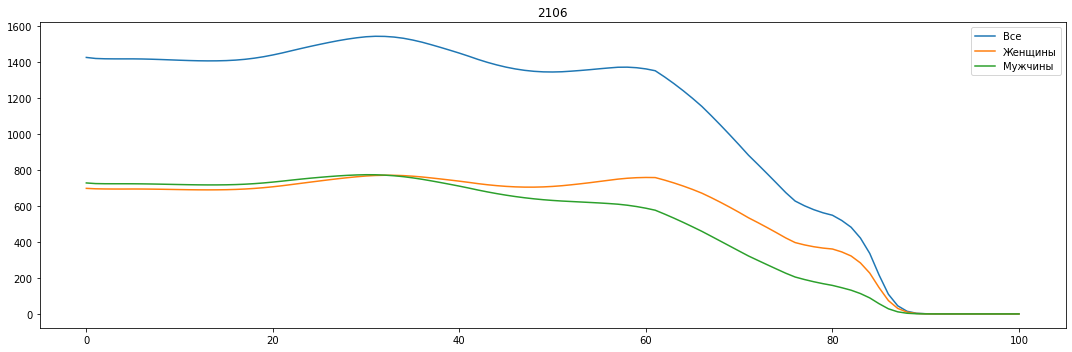

In [15]:
import time
def get_next_year(year, next_year):
    
    clear_output()
    
    survive_df_new[next_year], female_df_new[next_year], male_df_new[next_year] = 0, 0, 0
    
    survive_df_new.loc[1:, next_year] = np.array(survive_df_new[year][:-1]) * np.array(survive_df_new['avg_survival'][1:])
    female_df_new.loc[1:, next_year] = np.array(female_df_new[year][:-1]) * np.array(female_df_new['avg_survival'][1:])
    male_df_new.loc[1:, next_year]= np.array(male_df_new[year][:-1]) * np.array(male_df_new['avg_survival'][1:])
    
    female_df_new.loc[0, next_year] = sum(female_df_new[next_year][20:40])*FF.mean()
    survive_df_new.loc[0, next_year] = sum(female_df_new[next_year][20:40])*F.mean()
    male_df_new.loc[0, next_year] = sum(female_df_new[next_year][20:40])*FM.mean()
    
    plt.figure(figsize = (15, 5))
    plt.subplot(1,1,1)
    plt.title(str(next_year))
    plt.plot(survive_df_new.index, survive_df_new[next_year])
    plt.plot(female_df_new.index, female_df_new[next_year])
    plt.plot(male_df_new.index, male_df_new[next_year])
    plt.legend(['Все', "Женщины", "Мужчины"])
    plt.tight_layout()
    plt.show()
    
    time.sleep(1)
    
    if next_year!=2106:
        get_next_year(next_year, next_year+1)
    
    return
    
survive_df_new['avg_survival'] = survive_df_new[survive_df_new.columns[56:]].mean(axis=1)
female_df_new['avg_survival'] = female_df_new[female_df_new.columns[56:]].mean(axis=1)
male_df_new['avg_survival'] = male_df_new[male_df_new.columns[56:]].mean(axis=1)

year = survive_df_new.columns[55]
next_year = year+1

get_next_year(year, next_year)

In [84]:
survive_df_new.columns.to_list()

[1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 '1950-1951',
 '1951-1952',
 '1952-1953',
 '1953-1954',
 '1954-1955',
 '1955-1956',
 '1956-1957',
 '1957-1958',
 '1958-1959',
 '1959-1960',
 '1960-1961',
 '1961-1962',
 '1962-1963',
 '1963-1964',
 '1964-1965',
 '1965-1966',
 '1966-1967',
 '1967-1968',
 '1968-1969',
 '1969-1970',
 '1970-1971',
 '1971-1972',
 '1972-1973',
 '1973-1974',
 '1974-1975',
 '1975-1976',
 '1976-1977',
 '1977-1978',
 '1978-1979',
 '1979-1980',
 '1980-1981',
 '1981-1982',
 '1982-1983',
 '1983-1984',
 '1984-1985',
 '1985-1986',
 '1986-1987',
 '1987-1988',
 '1988-1989',
 '1989-1990',
 '1990-1991',
 '1991-1992',
 '1992-1993',
 '1993

In [37]:
columns_survival = ['1950-1951', '1951-1952', '1952-1953', '1953-1954', '1954-1955', '1955-1956', '1956-1957', '1957-1958', '1958-1959', '1959-1960', '1960-1961',
'1961-1962', '1962-1963', '1963-1964', '1964-1965', '1965-1966', '1966-1967', '1967-1968', '1968-1969', '1969-1970', '1970-1971', '1971-1972',
'1972-1973', '1973-1974', '1974-1975', '1975-1976', '1976-1977', '1977-1978', '1978-1979', '1979-1980', '1980-1981', '1981-1982', '1982-1983',
'1983-1984', '1984-1985', '1985-1986', '1986-1987', '1987-1988', '1988-1989', '1989-1990', '1990-1991', '1991-1992', '1992-1993', '1993-1994',
'1994-1995', '1995-1996', '1996-1997', '1997-1998', '1998-1999', '1999-2000', '2000-2001', '2001-2002', '2002-2003', '2003-2004']

In [17]:
years = [range(2005, 2015), range(2005,2025), range(2005, 2055), range(2005, 2105)]

In [132]:
def Model_my(year, params):
#     FF, FM, s1, s2, s3, s4, s5, s6, s7 = params
    r = 0
    for i in range(len(params)):
        if i==0:
            r+=sum(female_df_new[year][20:40])*params[i]
        elif i == 1:
            r+=sum(female_df_new[year][20:40])*params[i]
        else:
            r+= survive_df_new[year-1][problem['names'][i]] * params[i]
    return r

def Evaluate(param_values, i):
    Y = []
#     for i in [2015, 2025, 2055, 2105]:
#         vals = []
    for params in param_values:
        res = Model_my(i, params)        
#         print(len(params, res))
        Y.append(res)
#         Y.update({i:vals})
    return Y

# Define the model inputs
problem = {
    'num_vars': 12,
    'names': [ 'FF', 'FM'],
    'bounds': [[FF.min(), FF.max()],
               [FM.min(), FM.max()]]
}
problem['names'].extend(list(range(1, 11)))
bounds = []
for i in range(1, 11):
    bounds.append([survive_df_new[columns_survival].loc[i].min(), survive_df_new[columns_survival].loc[i].max()])
problem['bounds'].extend(bounds)
# Generate samples
N = [10, 20, 50, 100]

Y2 = []
# Run model (example)
for n in N:
    param_values2 = saltelli.sample(problem, n)  
    Y2.append(Evaluate(param_values2, 2005+n))

# Perform analysis
# Si = sobol.analyze(problem, Y)
Sis2 = []
for i in Y2:
    Sis2.append(sobol.analyze(problem, np.array(i)))
    
# # Print the first-order sensitivity indices
# print("__________________")
# print(Si['S1'])

In [142]:
Sis_1 = []
for i in range(len(Sis2)):
    Sis_1.append(Sis2[i]['S1'])
df_res2 =pd.DataFrame(Sis_1)

In [144]:
df_res2.loc[0]

0     0.078055
1     0.171312
2     0.324234
3     0.135844
4     0.004104
5     0.047629
6    -0.003689
7    -0.003189
8    -0.005764
9    -0.002999
10   -0.002340
11   -0.004897
Name: 0, dtype: float64

Text(0, 0.5, 'Индекс Соболя')

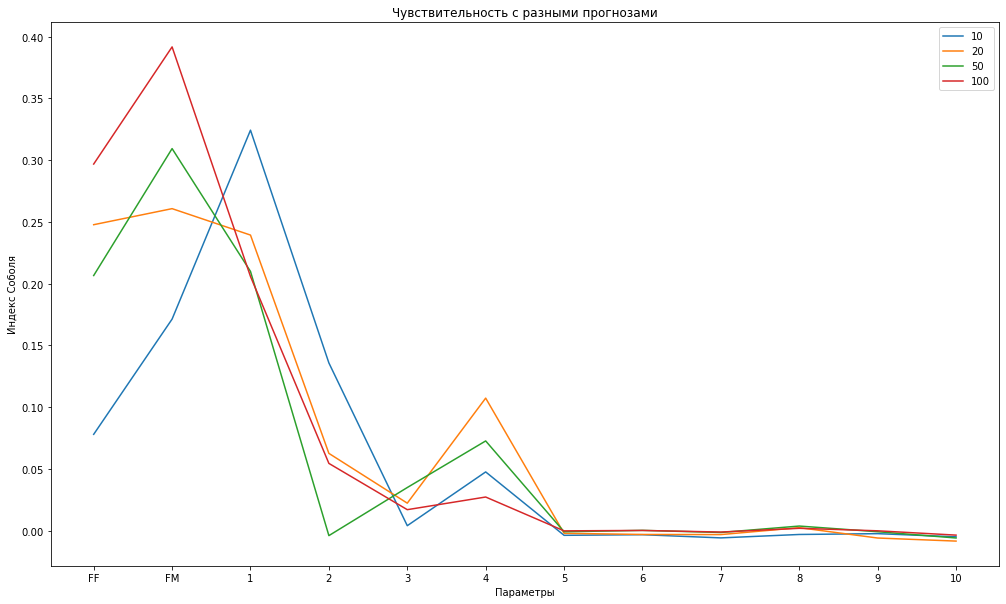

In [145]:
plt.figure(figsize=(17, 10))
plt.plot(['FF', 'FM', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], df_res2.loc[0])
plt.plot(df_res2.loc[1])
plt.plot(df_res2.loc[2])
plt.plot(df_res2.loc[3])
plt.legend([10, 20, 50, 100])
plt.title('Чувствительность с разными прогнозами')
plt.xlabel('Параметры')
plt.ylabel('Индекс Соболя')

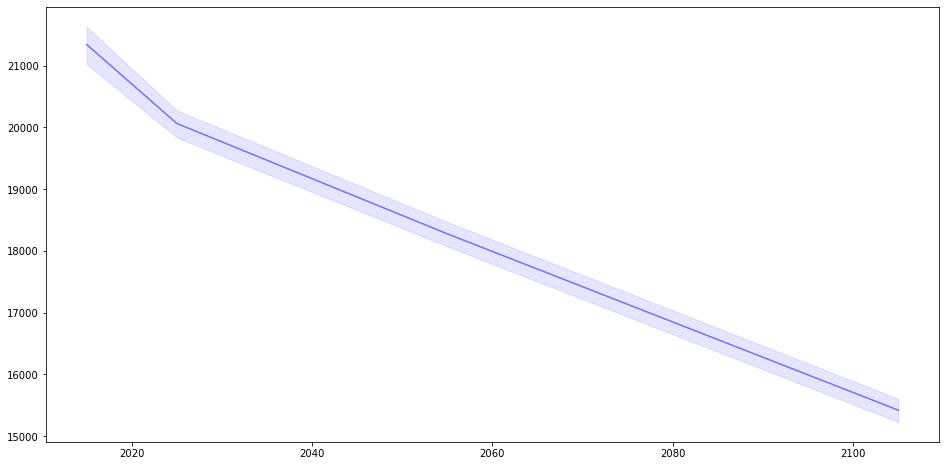

In [134]:
upper = []
lower = []
mean = []
for i in Y2:
    mean.append(np.mean(i))
    lower.append(np.percentile(i, 25, axis=0))
    upper.append(np.percentile(i, 75, axis=0))
plt.figure(figsize=(16,8))
# plt.plot(years[3], survive_df_new[years[3]][:11].sum(), color = 'red')
plt.fill_between([2015, 2025, 2055, 2105], lower, upper, color='b', alpha=.1)
plt.plot([2015, 2025, 2055, 2105], mean, color = 'blue', alpha=0.5)

In [38]:
def Model_my(year, params):
#     FF, FM, s1, s2, s3, s4, s5, s6, s7 = params
    r = 0
    for i in range(len(params)):
        if i==0:
            r+=sum(female_df_new[year][20:40])*params[i]
        elif i == 1:
            r+=sum(female_df_new[year][20:40])*params[i]
        else:
            r+= survive_df_new[year-1][problem['names'][i]] * params[i]
    return r

def Evaluate(param_values):
    Y = {}
    for i in years[3]:
        vals = []
        for params in param_values:
            res = Model_my(i, params)        
    #         print(len(params, res))
            vals.append(res)
        Y.update({i:vals})
    return Y

# Define the model inputs
problem = {
    'num_vars': 12,
    'names': [ 'FF', 'FM'],
    'bounds': [[FF.min(), FF.max()],
               [FM.min(), FM.max()]]
}
problem['names'].extend(list(range(1, 11)))
bounds = []
for i in range(1, 11):
    bounds.append([survive_df_new[columns_survival].loc[i].min(), survive_df_new[columns_survival].loc[i].max()])
problem['bounds'].extend(bounds)
# Generate samples
param_values = saltelli.sample(problem, 1000)

# Run model (example)
Y = Evaluate(param_values)

# Perform analysis
# Si = sobol.analyze(problem, Y)
Sis = []
for i in years[3]:
    Sis.append(sobol.analyze(problem, np.array(Y[i])))
    
# # Print the first-order sensitivity indices
# print("__________________")
# print(Si['S1'])

In [18]:
df_conf_100 = pd.read_csv('conf100.csv')

In [39]:
problem

{'num_vars': 12,
 'names': ['FF', 'FM', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'bounds': [[0.028420539601632287, 0.061376670979300545],
  [0.029834876986983207, 0.06597755995066999],
  [0.8273300122671873, 1.1028780098779307],
  [0.9014251026634089, 1.053331561562049],
  [0.9289879672014991, 1.0377163409152586],
  [0.943275572282979, 1.0300260858060724],
  [0.9981762637658637, 1.004665529766745],
  [0.9967180840431674, 1.0056369038710469],
  [0.9967072776049978, 1.0056369038710469],
  [0.9966963997665249, 1.0056369038710469],
  [0.996685449817769, 1.0056369038710469],
  [0.9966744270393061, 1.0056369038710469]]}

In [40]:
Sis

[{'S1': array([ 3.73411616e-01,  4.47060581e-01,  1.15339760e-01,  3.42950172e-02,
          1.74024835e-02,  1.01328680e-02,  4.17853072e-05,  7.52482255e-05,
          4.81713465e-05,  1.50704300e-04,  6.26470180e-05, -3.39312984e-04]),
  'S1_conf': array([0.04172096, 0.05894646, 0.02713819, 0.01672759, 0.01172346,
         0.00824035, 0.00062798, 0.00084397, 0.00090885, 0.00095384,
         0.00109984, 0.0010603 ]),
  'ST': array([3.72808724e-01, 4.49543025e-01, 1.12749451e-01, 3.48111127e-02,
         1.80950303e-02, 9.73817063e-03, 5.45728397e-05, 1.02641626e-04,
         1.02592829e-04, 1.02972281e-04, 1.55083728e-04, 1.56451628e-04]),
  'ST_conf': array([3.16595508e-02, 3.77049503e-02, 9.77089692e-03, 3.06042525e-03,
         1.77508876e-03, 8.13887266e-04, 5.10043581e-06, 8.12224369e-06,
         1.08241283e-05, 9.57329954e-06, 1.49622744e-05, 1.37138963e-05]),
  'S2': array([[            nan, -3.64356236e-03,  1.02117636e-04,
          -3.03543753e-04, -2.59664145e-03, -1.2645

In [41]:
Sis_1 = []
for i in range(len(Sis)):
    Sis_1.append(Sis[i]['S1'])

In [210]:
df_res[100] = pd.DataFrame(Sis_1).abs().max()

In [43]:
df_res = pd.DataFrame(Sis_1)

In [60]:
df_res.to_csv('df_res.csv', index = False)

In [227]:
df_res[[10, 20, 50, 100]].to_csv('result.csv', index = False)

In [125]:
df_res

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.373412,0.447061,0.115340,0.034295,0.017402,0.010133,0.000042,0.000075,0.000048,0.000151,0.000063,-0.000339
1,0.371541,0.444885,0.117626,0.034505,0.017353,0.011872,0.000040,0.000073,0.000046,0.000147,0.000026,-0.000339
2,0.373589,0.447432,0.114358,0.033783,0.017053,0.011693,0.000048,0.000071,0.000045,0.000145,0.000025,-0.000298
3,0.335828,0.401580,0.205036,0.029311,0.014606,0.010430,0.000046,0.000082,0.000044,0.000118,0.000019,-0.000271
4,0.326131,0.390289,0.200115,0.057403,0.013681,0.009851,0.000047,0.000081,0.000056,0.000111,0.000019,-0.000256
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.314256,0.375776,0.199700,0.058427,0.028981,0.019759,0.000097,0.000184,0.000131,0.000267,0.000103,-0.000330
96,0.314127,0.375624,0.199875,0.058494,0.029011,0.019773,0.000097,0.000184,0.000131,0.000266,0.000102,-0.000329
97,0.313938,0.375397,0.200103,0.058592,0.029067,0.019809,0.000097,0.000184,0.000131,0.000266,0.000102,-0.000329
98,0.313694,0.375105,0.200378,0.058719,0.029145,0.019866,0.000098,0.000184,0.000131,0.000266,0.000102,-0.000329


In [95]:
pd.DataFrame(param_values)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.035662,0.033329,0.970217,1.004229,0.959462,1.021978,0.998474,1.004740,1.001181,0.997316,0.997446,0.998959
1,0.033731,0.033329,0.970217,1.004229,0.959462,1.021978,0.998474,1.004740,1.001181,0.997316,0.997446,0.998959
2,0.035662,0.043706,0.970217,1.004229,0.959462,1.021978,0.998474,1.004740,1.001181,0.997316,0.997446,0.998959
3,0.035662,0.033329,0.866886,1.004229,0.959462,1.021978,0.998474,1.004740,1.001181,0.997316,0.997446,0.998959
4,0.035662,0.033329,0.970217,0.957648,0.959462,1.021978,0.998474,1.004740,1.001181,0.997316,0.997446,0.998959
...,...,...,...,...,...,...,...,...,...,...,...,...
25995,0.037899,0.053677,1.061035,1.011572,0.975973,0.967293,1.002844,1.001365,1.000549,0.999198,1.004942,1.005029
25996,0.037899,0.053677,1.061035,1.011572,0.975973,0.967293,1.002844,1.001365,1.003112,0.999704,1.004942,1.005029
25997,0.037899,0.053677,1.061035,1.011572,0.975973,0.967293,1.002844,1.001365,1.003112,0.999198,0.996812,1.005029
25998,0.037899,0.053677,1.061035,1.011572,0.975973,0.967293,1.002844,1.001365,1.003112,0.999198,1.004942,1.001108


In [124]:
pd.DataFrame(Y)

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,...,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104
0,15494.347897,15407.375540,15235.966290,15964.928951,16733.246157,17493.422800,18280.631379,19075.518417,19724.388612,20350.120517,...,15239.542075,15183.630129,15141.737603,15112.691137,15095.022763,15086.999015,15086.648688,15091.779697,15100.244136,15109.946875
1,15452.844618,15365.448170,15193.610046,15922.139313,16690.018880,17449.753921,18237.407573,19032.737175,19682.048915,20308.222826,...,15210.650761,15154.704655,15112.772381,15083.685291,15065.979813,15057.926558,15057.557801,15062.684603,15071.161878,15080.897006
2,15717.377576,15632.684187,15463.579617,16194.871243,16965.540227,17728.089945,18512.906793,19305.415592,19951.913021,20575.269678,...,15394.797768,15339.069395,15297.390464,15268.562303,15251.093319,15243.228133,15242.976842,15248.130459,15256.525922,15266.054609
3,15348.381092,15258.054165,15087.635455,15752.748526,16518.895341,17276.878722,18061.872556,18854.524793,19505.647357,20133.618927,...,15093.490487,15037.540018,14995.528306,14966.308964,14948.439440,14940.210107,14939.672009,14944.653694,14953.024868,14962.706315
4,15428.059716,15340.062472,15168.859665,15898.267485,16637.890002,17397.091248,18183.314151,18977.205859,19625.071711,20251.815854,...,15173.877917,15117.992982,15076.083143,15046.983113,15029.237047,15021.122899,15020.680181,15025.726803,15034.124134,15043.784959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25995,16094.978829,16007.058405,15838.507984,16628.189308,17408.053939,18186.389226,18938.162837,19732.700018,20371.775448,20988.968019,...,15685.202313,15629.684143,15588.299271,15559.802194,15542.656946,15535.064882,15535.001301,15540.223719,15548.540296,15557.816905
25996,16099.020682,16011.098356,15842.548380,16632.230301,17412.427111,18190.826208,18942.594112,19737.118890,20376.167613,20994.932378,...,15689.600961,15634.057570,15592.652626,15564.140734,15546.985422,15539.387442,15539.321511,15544.544587,15552.864295,15562.145756
25997,16085.210406,15999.734328,15831.183861,16620.864859,17401.060319,18179.392173,18930.107290,19724.638794,20363.706737,20982.512316,...,15677.066659,15621.618987,15580.296001,15551.851868,15534.749754,15527.190238,15527.149792,15532.387061,15540.711289,15549.989151
25998,16092.014675,16004.094518,15836.722327,16626.403959,17406.600259,18184.933158,18936.700620,19730.718510,20369.772209,20988.549996,...,15683.127943,15627.639233,15586.282136,15557.811004,15540.689145,15533.117247,15533.069993,15538.305237,15546.631462,15555.914611


Text(0, 0.5, 'Индекс Соболя')

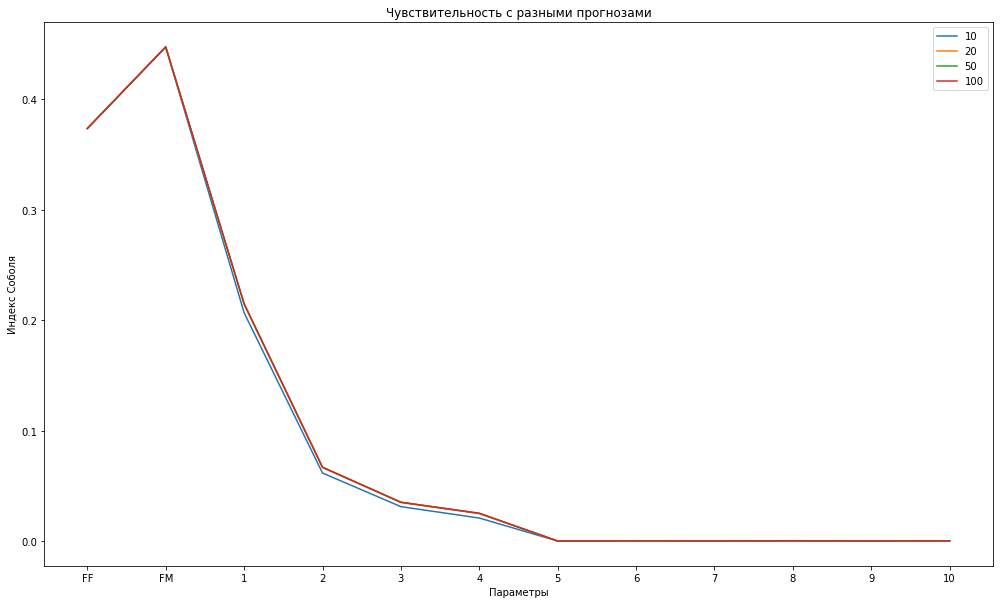

In [225]:
plt.figure(figsize=(17, 10))
plt.plot(['FF', 'FM', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], df_res[10])
plt.plot(df_res[20])
plt.plot(df_res[50])
plt.plot(df_res[100])
plt.legend([10, 20, 50, 100])
plt.title('Чувствительность с разными прогнозами')
plt.xlabel('Параметры')
plt.ylabel('Индекс Соболя')

In [192]:
df_res = pd.DataFrame(pd.DataFrame(Sis_1).abs().max()).rename(columns = {0:20})

Text(0.5, 1.0, 'Чувствительность прогноза для 100 лет')

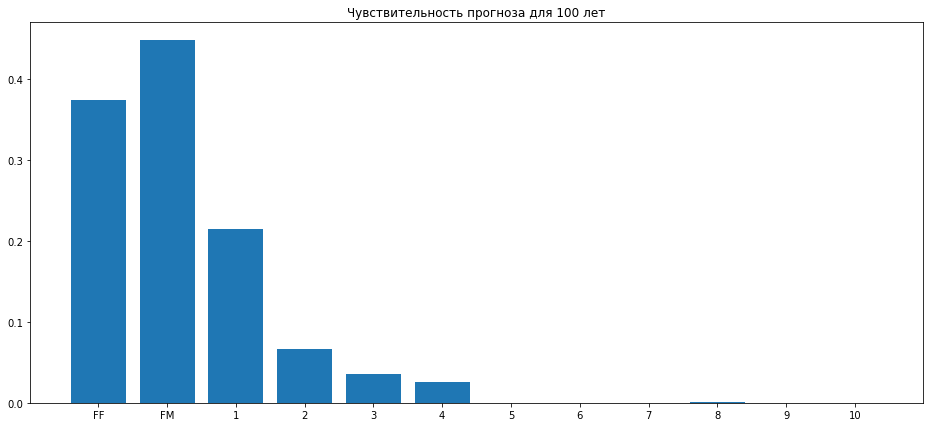

In [61]:
plt.figure(figsize=(16, 7))
plt.bar(['FF', 'FM', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],pd.DataFrame(Sis_1).abs().max())
plt.title('Чувствительность прогноза для 100 лет')

In [279]:
Sis_conf = []
for i in range(len(Sis)):
    Sis_conf.append(Sis[i]['S1_conf'])

In [241]:
df_conf_10 = pd.DataFrame(Sis_conf)

In [249]:
df_conf_20 = pd.DataFrame(Sis_conf)

In [254]:
df_conf_50 = pd.DataFrame(Sis_conf)

In [280]:
df_conf_100 = pd.DataFrame(Sis_conf)

In [289]:
df_conf_10.to_csv('conf10.csv', index=False)
df_conf_20.to_csv('conf20.csv', index=False)
df_conf_50.to_csv('conf50.csv', index=False)
df_conf_100.to_csv('conf100.csv', index=False)

In [112]:
pd.DataFrame(param_values)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.035662,0.033329,0.970217,1.004229,0.959462,1.021978,0.998474,1.004740,1.001181,0.997316,0.997446,0.998959
1,0.033731,0.033329,0.970217,1.004229,0.959462,1.021978,0.998474,1.004740,1.001181,0.997316,0.997446,0.998959
2,0.035662,0.043706,0.970217,1.004229,0.959462,1.021978,0.998474,1.004740,1.001181,0.997316,0.997446,0.998959
3,0.035662,0.033329,0.866886,1.004229,0.959462,1.021978,0.998474,1.004740,1.001181,0.997316,0.997446,0.998959
4,0.035662,0.033329,0.970217,0.957648,0.959462,1.021978,0.998474,1.004740,1.001181,0.997316,0.997446,0.998959
...,...,...,...,...,...,...,...,...,...,...,...,...
25995,0.037899,0.053677,1.061035,1.011572,0.975973,0.967293,1.002844,1.001365,1.000549,0.999198,1.004942,1.005029
25996,0.037899,0.053677,1.061035,1.011572,0.975973,0.967293,1.002844,1.001365,1.003112,0.999704,1.004942,1.005029
25997,0.037899,0.053677,1.061035,1.011572,0.975973,0.967293,1.002844,1.001365,1.003112,0.999198,0.996812,1.005029
25998,0.037899,0.053677,1.061035,1.011572,0.975973,0.967293,1.002844,1.001365,1.003112,0.999198,1.004942,1.001108


Text(0.5, 1.0, 'Интервалы параметров')

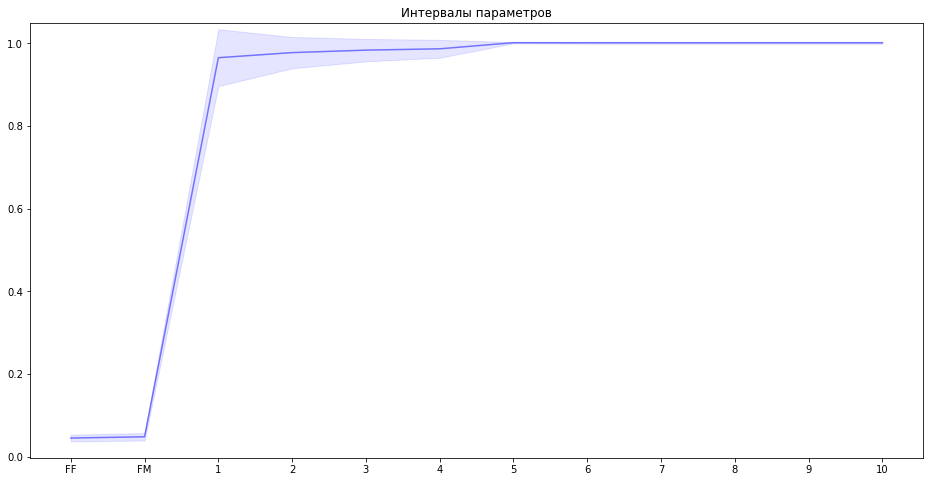

In [128]:
upper_p = []
lower_p = []
mean_p = []
for i in range(12):
    mean_p.append(np.mean(pd.DataFrame(param_values)[i]))
    lower_p.append(np.percentile(pd.DataFrame(param_values)[i], 25, axis=0))
    upper_p.append(np.percentile(pd.DataFrame(param_values)[i], 75, axis=0))
    
plt.figure(figsize=(16,8))
plt.fill_between(list(range(12)), lower_p, upper_p, color='b', alpha=.1)
plt.plot(['FF', 'FM', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], mean_p, color = 'blue', alpha=0.5)
plt.title('Интервалы параметров')

<BarContainer object of 12 artists>

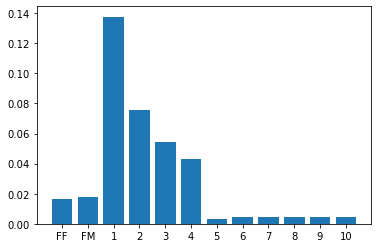

In [129]:
plt.bar(['FF', 'FM', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],np.array(upper_p)-np.array(lower_p))

Text(0.5, 1.0, 'Анализ неопредленности для прогноза 10 лет')

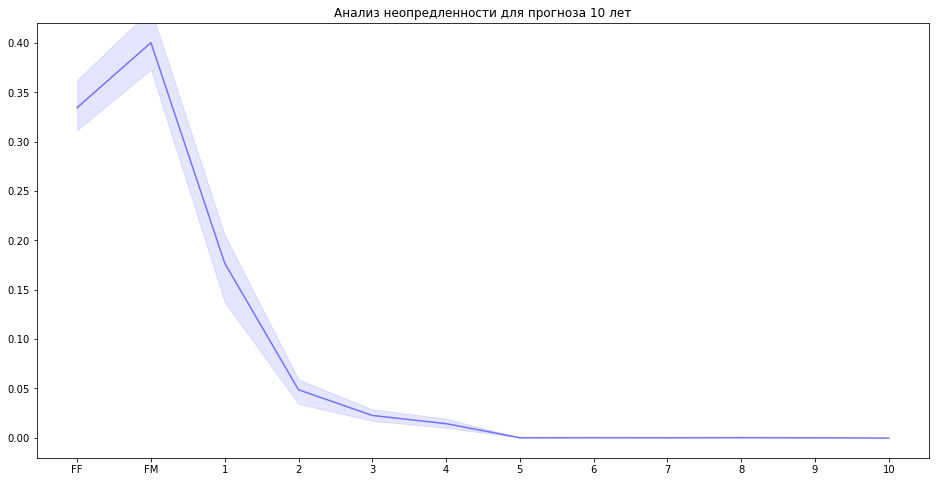

In [107]:
upper_10 = []
lower_10 = []
mean_10 = []
for i in range(12):
    mean_10.append(np.mean(df_res[:10][i]))
    lower_10.append(np.percentile(df_res[:10][i], 25, axis=0))
    upper_10.append(np.percentile(df_res[:10][i], 75, axis=0))
    
plt.figure(figsize=(16,8))
plt.fill_between(list(range(12)), lower_10, upper_10, color='b', alpha=.1)
plt.plot(['FF', 'FM', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], mean_10, color = 'blue', alpha=0.5)
plt.title('Анализ неопредленности для прогноза 10 лет')

<BarContainer object of 12 artists>

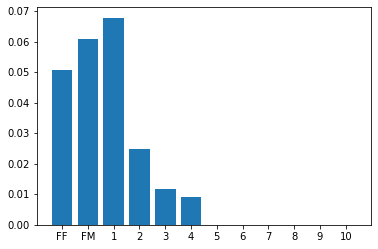

In [108]:
plt.bar(['FF', 'FM', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],np.array(upper_10)-np.array(lower_10))

Text(0.5, 1.0, 'Анализ неопредленности для прогноза 20 лет')

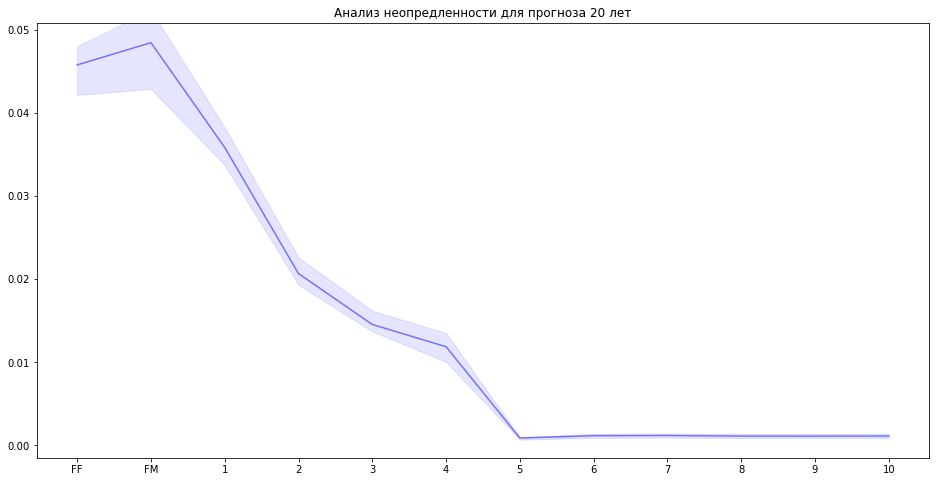

In [104]:
upper_20 = []
lower_20 = []
mean_20 = []
for i in range(12):
    mean_20.append(np.mean(df_conf_100[:20][str(i)]))
    lower_20.append(np.percentile(df_conf_100[:20][str(i)], 25, axis=0))
    upper_20.append(np.percentile(df_conf_100[:20][str(i)], 75, axis=0))
    
plt.figure(figsize=(16,8))
plt.fill_between(list(range(12)), lower_20, upper_20, color='b', alpha=.1)
plt.plot(['FF', 'FM', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], mean_20, color = 'blue', alpha=0.5)
plt.title('Анализ неопредленности для прогноза 20 лет')

<BarContainer object of 12 artists>

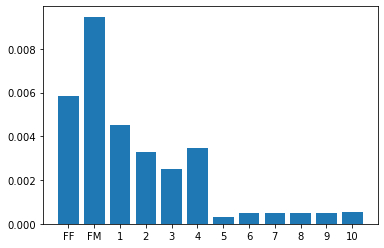

In [105]:
plt.bar(['FF', 'FM', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],np.array(upper_20)-np.array(lower_20))

In [31]:
lower_50

[]

Text(0.5, 1.0, 'Анализ неопредленности для прогноза 50 лет')

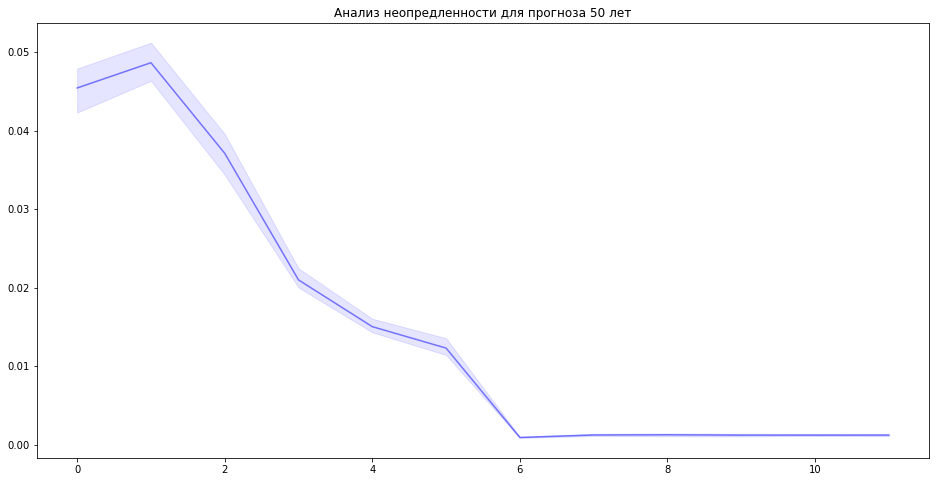

In [32]:
upper_50 = []
lower_50 = []
mean_50 = []
for i in range(12):
    mean_50.append(np.mean(df_conf_100[:50][str(i)]))
    lower_50.append(np.percentile(df_conf_100[:50][str(i)], 25, axis=0))
    upper_50.append(np.percentile(df_conf_100[:50][str(i)], 75, axis=0))
    
plt.figure(figsize=(16,8))
plt.fill_between(list(range(12)), lower_50, upper_50, color='b', alpha=.1)
plt.plot(list(range(12)), mean_50, color = 'blue', alpha=0.5)
plt.title('Анализ неопредленности для прогноза 50 лет')

<BarContainer object of 12 artists>

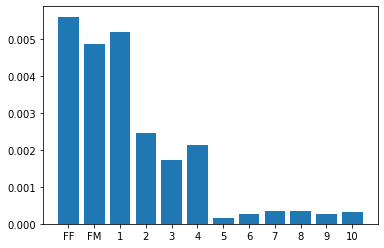

In [33]:
plt.bar(['FF', 'FM', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],np.array(upper_50)-np.array(lower_50))

In [72]:
upper_100 = []
lower_100 = []
mean_100 = []
for i in range(12):
    mean_100.append(np.mean(df_res[:100][i]))
    lower_100.append(np.percentile(df_res[:100][i], 5, axis=0))
    upper_100.append(np.percentile(df_res[:100][i], 95, axis=0))
#     lower_100.append(df_res[:100][i].abs().min())
#     upper_100.append(df_res[:100][i].abs().max())

Text(0.5, 1.0, 'Анализ неопредленности для прогноза 100 лет')

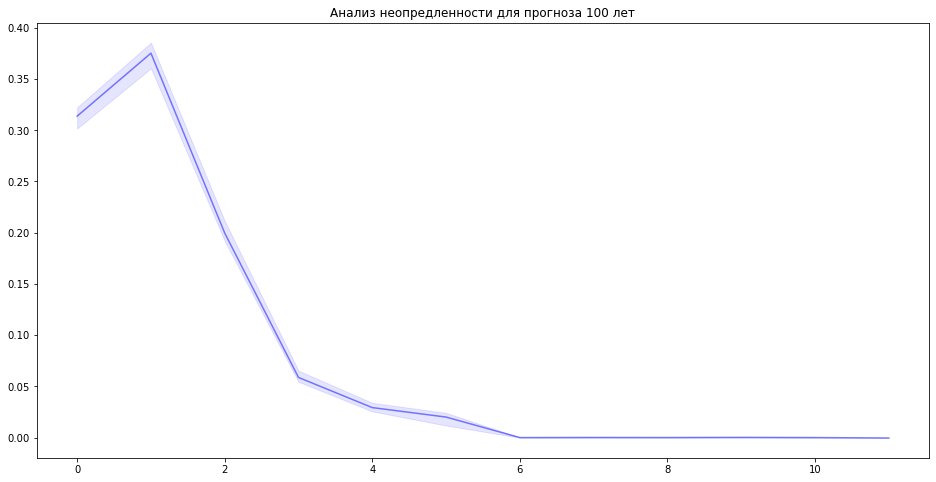

In [73]:
plt.figure(figsize=(16,8))
plt.fill_between(list(range(12)), lower_100, upper_100, color='b', alpha=.1)
plt.plot(list(range(12)), mean_100, color = 'blue', alpha=0.5)
plt.title('Анализ неопредленности для прогноза 100 лет')

<BarContainer object of 12 artists>

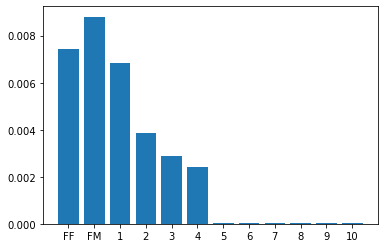

In [67]:
plt.bar(['FF', 'FM', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],np.array(upper_100)-np.array(lower_100))

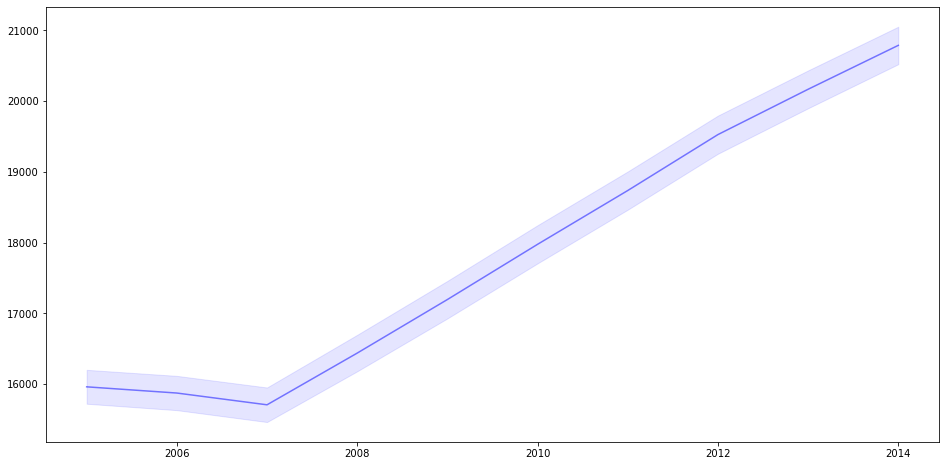

In [86]:
upper = []
lower = []
mean = []
for i in years[0]:
    mean.append(np.mean(Y[i]))
    lower.append(np.percentile(Y[i], 25, axis=0))
    upper.append(np.percentile(Y[i], 75, axis=0))
plt.figure(figsize=(16,8))
# plt.plot(years[3], survive_df_new[years[3]][:11].sum(), color = 'red')
plt.fill_between(years[0], lower, upper, color='b', alpha=.1)
plt.plot(years[0], mean, color = 'blue', alpha=0.5)

(array([2., 1., 0., 0., 0., 1., 0., 0., 2., 4.]),
 array([479.28559851, 485.42014142, 491.55468433, 497.68922724,
        503.82377015, 509.95831306, 516.09285598, 522.22739889,
        528.3619418 , 534.49648471, 540.63102762]),
 <a list of 10 Patch objects>)

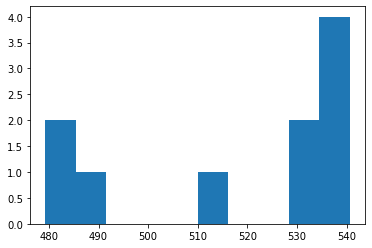

In [87]:
plt.hist(np.array(upper)-np.array(lower))

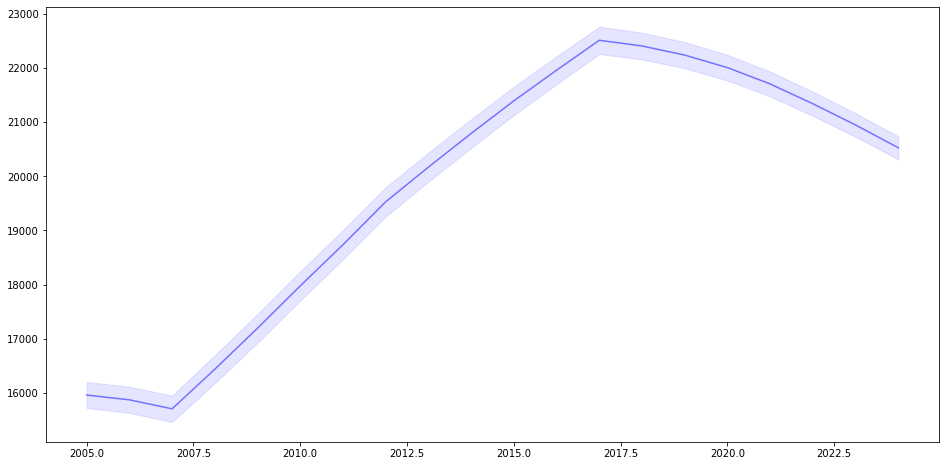

In [88]:
upper = []
lower = []
mean = []
for i in years[1]:
    mean.append(np.mean(Y[i]))
    lower.append(np.percentile(Y[i], 25, axis=0))
    upper.append(np.percentile(Y[i], 75, axis=0))
plt.figure(figsize=(16,8))
# plt.plot(years[3], survive_df_new[years[3]][:11].sum(), color = 'red')
plt.fill_between(years[1], lower, upper, color='b', alpha=.1)
plt.plot(years[1], mean, color = 'blue', alpha=0.5)

(array([1., 1., 1., 1., 2., 3., 2., 2., 1., 6.]),
 array([423.1305843 , 434.88062863, 446.63067296, 458.38071729,
        470.13076163, 481.88080596, 493.63085029, 505.38089462,
        517.13093896, 528.88098329, 540.63102762]),
 <a list of 10 Patch objects>)

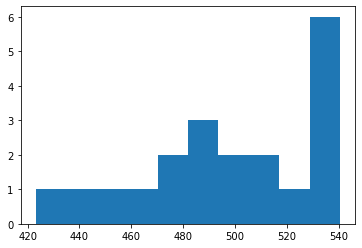

In [89]:
plt.hist(np.array(upper)-np.array(lower))

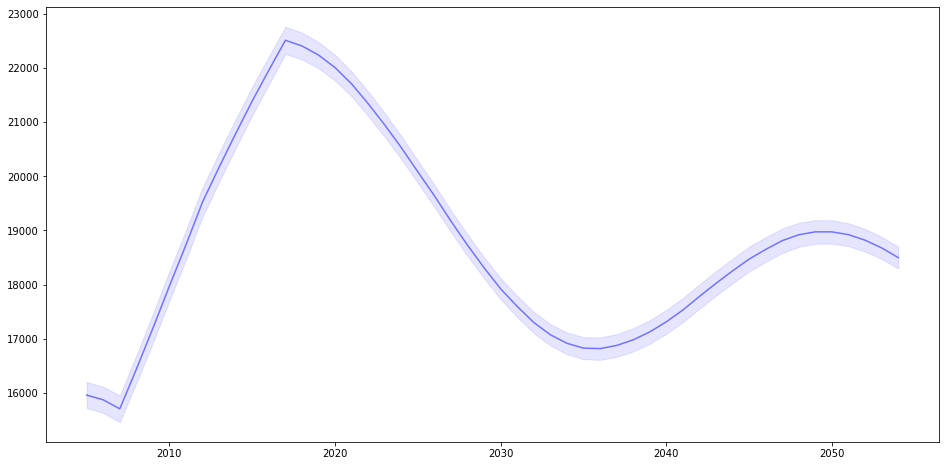

In [90]:
upper = []
lower = []
mean = []
for i in years[2]:
    mean.append(np.mean(Y[i]))
    lower.append(np.percentile(Y[i], 25, axis=0))
    upper.append(np.percentile(Y[i], 75, axis=0))
plt.figure(figsize=(16,8))
# plt.plot(years[3], survive_df_new[years[3]][:11].sum(), color = 'red')
plt.fill_between(years[2], lower, upper, color='b', alpha=.1)
plt.plot(years[2], mean, color = 'blue', alpha=0.5)

(array([8., 7., 5., 6., 8., 1., 4., 2., 3., 6.]),
 array([385.54124571, 401.0502239 , 416.55920209, 432.06818028,
        447.57715847, 463.08613667, 478.59511486, 494.10409305,
        509.61307124, 525.12204943, 540.63102762]),
 <a list of 10 Patch objects>)

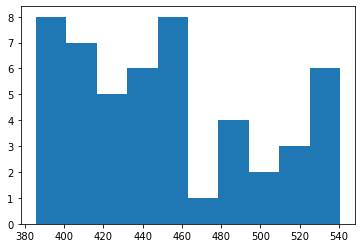

In [91]:
plt.hist(np.array(upper)-np.array(lower))

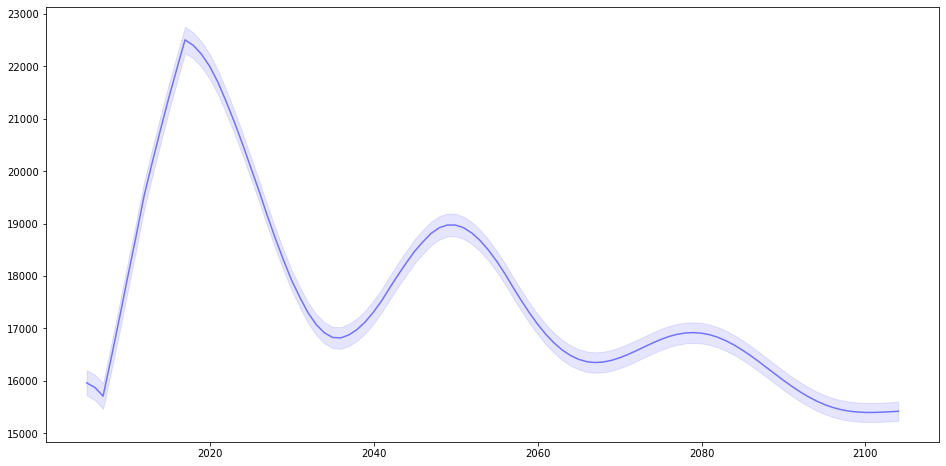

In [127]:
upper = []
lower = []
mean = []
for i in years[3]:
    mean.append(np.mean(Y[i]))
    lower.append(np.percentile(Y[i], 25, axis=0))
    upper.append(np.percentile(Y[i], 75, axis=0))
plt.figure(figsize=(16,8))
# plt.plot(years[3], survive_df_new[years[3]][:11].sum(), color = 'red')
plt.fill_between(years[3], lower, upper, color='b', alpha=.1)
plt.plot(years[3], mean, color = 'blue', alpha=0.5)

(array([21., 27., 16.,  6.,  9.,  5.,  4.,  3.,  2.,  7.]),
 array([361.82551742, 379.70606844, 397.58661946, 415.46717048,
        433.3477215 , 451.22827252, 469.10882354, 486.98937456,
        504.86992558, 522.7504766 , 540.63102762]),
 <a list of 10 Patch objects>)

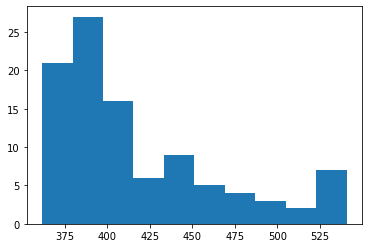

In [85]:
plt.hist(np.array(upper)-np.array(lower))

In [1]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import random,math

def Model(x1,x2,x3):
    return x1+x2+x3

def Evaluate(param_values):
    Y = []
    for params in param_values:
        x1,x2,x3 = params
        res = Model(x1,x2,x3)                
        Y.append(res)
    return np.array(Y)
    
# Define the model inputs
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-1, 1],
               [-1, 1],
               [-1, 1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1000)

# Run model (example)
Y = Evaluate(param_values)

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=False)

# Print the first-order sensitivity indices
print("__________________")
print(Si['S1'])

__________________
[0.33447069 0.33429685 0.33066248]


In [2]:
param_values

array([[-0.56054688, -0.80664062,  0.03710938],
       [ 0.35351562, -0.80664062,  0.03710938],
       [-0.56054688, -0.43945312,  0.03710938],
       ...,
       [-0.01660156,  0.22363281,  0.47167969],
       [-0.01660156,  0.60449219, -0.73144531],
       [-0.01660156,  0.60449219,  0.47167969]])